In [1]:
%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt 

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

from flask import Flask, jsonify

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
conn = engine.connect()

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'])

id
station
date
prcp
tobs


In [10]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
query = """
            SELECT 
                date,
                Sum(prcp) as "Total_precipitation"
            FROM 
                measurement
            GROUP BY
                date
        """

In [14]:
df = pd.read_sql(query, conn)
df

,date,Total_precipitation
0,2010-01-01,1.06
1,2010-01-02,0.02
2,2010-01-03,0.00
3,2010-01-04,0.01
4,2010-01-05,0.03
...,...,...
2787,2017-08-19,0.09
2788,2017-08-20,0.01
2789,2017-08-21,0.58
2790,2017-08-22,0.50


In [15]:
# Calculate the date 1 year ago from the last data point in the database
print(df.date.max())
cleared_date = dt.date(2017,8,23) - dt.timedelta(days=365)
cleared_date

2017-08-23


datetime.date(2016, 8, 23)

In [16]:
# Performed a query to retrieve the data and precipitation scores
query2 = """
            SELECT 
                date,
                prcp
            FROM 
                measurement
            WHERE
                date > '2016-08-23'
        """

In [17]:
# Saved the query results as a Pandas DataFrame and set the index to the date column
df2 = pd.read_sql(query2, conn).reset_index(drop=True)
df2

,date,prcp
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2218,2017-08-19,0.09
2219,2017-08-20,NaN
2220,2017-08-21,0.56
2221,2017-08-22,0.50


In [18]:
# Sorted the dataframe by date
df2 = df2.sort_values('date')
df2

,date,prcp
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
...,...,...
1522,2017-08-22,0.00
1523,2017-08-23,0.08
359,2017-08-23,0.00
1005,2017-08-23,0.00


In [19]:
df2['Date'] = pd.to_datetime(df2.date)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 0 to 2222
Data columns (total 3 columns):
date    2223 non-null object
prcp    2015 non-null float64
Date    2223 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 69.5+ KB


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


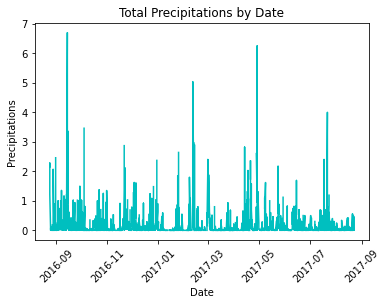

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df2.Date, df2.prcp, color = "c")
plt.xticks(rotation=45)
plt.title("Total Precipitations by Date")
plt.xlabel("Date")
plt.ylabel("Precipitations")
plt.show()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Design a query to show how many stations are available in this dataset?
query3 = """
            SELECT 
                station,
                count(station) as 'Station_Count'
            FROM 
                measurement
            GROUP BY 
                station
            """

In [23]:
df3 = pd.read_sql(query3, conn)
df3

,station,Station_Count
0,USC00511918,1979
1,USC00513117,2709
2,USC00514830,2202
3,USC00516128,2612
4,USC00517948,1372
5,USC00518838,511
6,USC00519281,2772
7,USC00519397,2724
8,USC00519523,2669


In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
df3.sort_values('Station_Count', ascending=False)

,station,Station_Count
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
query4 = """
            SELECT 
                station,
                max(tobs) as "Max_temp", 
                min(tobs) as "Min_temp",
                avg(tobs) as "Avg_temp"
            FROM 
                measurement
            WHERE 
                station = "USC00519281"
            GROUP BY 
                station
            """

In [26]:
df4 = pd.read_sql(query4, conn)
df4

,station,Max_temp,Min_temp,Avg_temp
0,USC00519281,85.0,54.0,71.663781


In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query5 = """
            SELECT 
                *
            FROM
                measurement
            """

In [28]:
df5 = pd.read_sql(query5, conn).sort_values('tobs', ascending=False)
df5

,id,station,date,prcp,tobs
212,213,USC00519397,2010-08-23,0.01,87.0
15209,15210,USC00511918,2010-09-19,0.00,87.0
2635,2636,USC00519397,2017-05-23,0.08,87.0
8990,8991,USC00517948,2017-07-03,NaN,87.0
16288,16289,USC00511918,2013-09-16,0.00,86.0
...,...,...,...,...,...
1763,1764,USC00519397,2014-12-31,0.05,56.0
14079,14080,USC00519281,2015-03-13,0.06,56.0
16123,16124,USC00511918,2013-04-03,0.00,55.0
13293,13294,USC00519281,2013-01-16,0.02,54.0


In [29]:
query6 = """
            SELECT
                *
            FROM
                measurement
            WHERE 
                station = 'USC00519397'
                AND
                date > '2016-08-23'
         """

In [30]:
df6 = pd.read_sql(query6, conn)
df6

,id,station,date,prcp,tobs
0,2365,USC00519397,2016-08-24,0.08,79.0
1,2366,USC00519397,2016-08-25,0.08,80.0
2,2367,USC00519397,2016-08-26,0.00,79.0
3,2368,USC00519397,2016-08-27,0.00,77.0
4,2369,USC00519397,2016-08-28,0.01,78.0
...,...,...,...,...,...
355,2720,USC00519397,2017-08-19,0.00,79.0
356,2721,USC00519397,2017-08-20,0.00,81.0
357,2722,USC00519397,2017-08-21,0.00,81.0
358,2723,USC00519397,2017-08-22,0.00,82.0


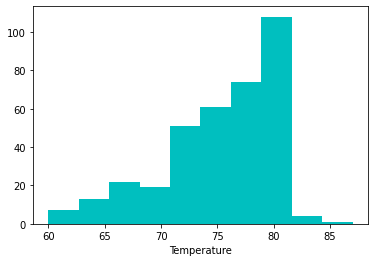

In [31]:
plt.hist(df6.tobs, color= "c")
plt.title("")
plt.xlabel("Temperature")
plt.show()


## Bonus Challenge Assignment

In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [33]:
# Used your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2016-08-23'
end_date = '2017-08-23'

calc_temps(start_date, end_date)

[(58.0, 74.59058295964125, 87.0)]

In [34]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp = 74.59058295964125
tmax = 87.0
tmin = 58.0
yerror = tmax - tmin

<function matplotlib.pyplot.show(*args, **kw)>

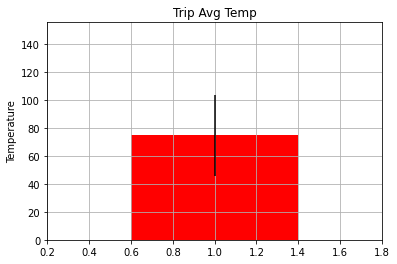

In [41]:
plt.bar(1, avg_temp, yerr = yerror, color="r")
plt.margins(0.5,0.5)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature")
plt.grid()
plt.show

In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [40]:
# Plot the daily normals as an area plot with `stacked=False`
